In [1]:
import gym


# 定义环境
class MyWrapper(gym.Wrapper):
    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        self.step_n += 1
        done = True if self.step_n >= 200 else terminated or truncated
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([-0.18417358,  0.9828937 ,  0.6155913 ], dtype=float32)

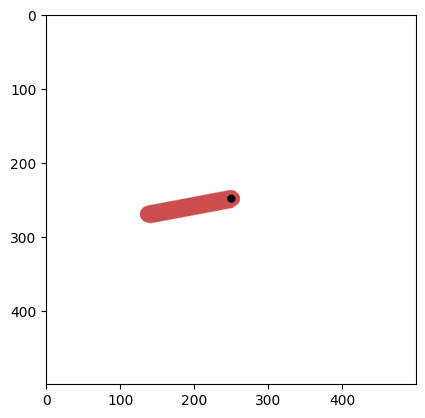

In [2]:
from matplotlib import pyplot as plt


# 打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [28]:
import torch


# DuelingDQN和其他DQN模型不同的点,它使用的是不同的模型结构
class VAnet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(3, 128),
            torch.nn.ReLU(),
        )

        self.fc_A = torch.nn.Linear(128, 11)
        self.fc_V = torch.nn.Linear(128, 1)

    def forward(self, x):
        # [5, 11] -> [5, 128] -> [5, 11]
        A = self.fc_A(self.fc(x))

        # [5, 11] -> [5, 128] -> [5, 1]
        V = self.fc_V(self.fc(x))

        # [5, 11] -> [5] -> [5, 1]
        A_mean = A.mean(dim=1).reshape(-1, 1)

        # [5, 11] - [5, 1] = [5, 11]
        A = A - A_mean

        # Q值由V值和A值计算得到
        # [5, 11] + [5, 1] = [5, 11]
        Q = A + V

        return Q


VAnet()(torch.randn(5, 3)).shape

torch.Size([5, 11])

In [29]:
import torch

# 计算动作的模型,也是真正要用的模型
model = VAnet()

# 经验网络,用于评估一个状态的分数
next_model = VAnet()

# 把model的参数复制给next_model
next_model.load_state_dict(model.state_dict())

model, next_model

(VAnet(
   (fc): Sequential(
     (0): Linear(in_features=3, out_features=128, bias=True)
     (1): ReLU()
   )
   (fc_A): Linear(in_features=128, out_features=11, bias=True)
   (fc_V): Linear(in_features=128, out_features=1, bias=True)
 ),
 VAnet(
   (fc): Sequential(
     (0): Linear(in_features=3, out_features=128, bias=True)
     (1): ReLU()
   )
   (fc_A): Linear(in_features=128, out_features=11, bias=True)
   (fc_V): Linear(in_features=128, out_features=1, bias=True)
 ))

In [30]:
import random


def get_action(state):
    # 走神经网络,得到一个动作
    state = torch.FloatTensor(state).reshape(1, 3)
    action = model(state).argmax().item()

    if random.random() < 0.01:
        action = random.choice(range(11))

    # 离散动作连续化
    action_continuous = action
    action_continuous /= 10
    action_continuous *= 4
    action_continuous -= 2

    return action, action_continuous


get_action([0.29292667, 0.9561349, 1.0957013])

(2, -1.2)

In [31]:
# 样本池
datas = []


# 向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    # 玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        # 初始化游戏
        state = env.reset()

        # 玩到游戏结束为止
        over = False
        while not over:
            # 根据当前状态得到一个动作
            action, action_continuous = get_action(state)

            # 执行动作,得到反馈
            next_state, reward, over, _ = env.step([action_continuous])

            # 记录数据样本
            datas.append((state, action, reward, next_state, over))

            # 更新游戏状态,开始下一个动作
            state = next_state

    update_count = len(datas) - old_count
    drop_count = max(len(datas) - 5000, 0)

    # 数据上限,超出时从最古老的开始删除
    while len(datas) > 5000:
        datas.pop(0)

    return update_count, drop_count


update_data(), len(datas)

((200, 0), 200)

In [32]:
# 获取一批数据样本
def get_sample():
    # 从样本池中采样
    samples = random.sample(datas, 64)

    # [b, 3]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
    # [b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
    # [b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    # [b, 3]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
    # [b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state, action, reward, next_state, over

(tensor([[ 0.9174,  0.3979, -6.0742],
         [ 0.8863, -0.4632, -4.6767],
         [-0.7301,  0.6833, -8.0000],
         [-0.6617, -0.7497, -8.0000],
         [ 0.7564,  0.6541, -6.2647],
         [-0.8625, -0.5061, -4.8888],
         [-0.8162, -0.5778, -8.0000],
         [ 0.5777,  0.8162, -6.5379],
         [ 0.8282,  0.5604, -6.2114],
         [-0.9412,  0.3379, -8.0000],
         [ 0.9071,  0.4210, -5.5953],
         [-0.7101, -0.7041, -8.0000],
         [-0.0144,  0.9999, -5.4274],
         [ 0.0663,  0.9978, -7.2427],
         [ 0.4543,  0.8908, -6.6961],
         [ 0.9901, -0.1406, -6.2275],
         [-0.9282, -0.3720, -8.0000],
         [ 0.6609,  0.7505, -6.4116],
         [-0.4436, -0.8962, -8.0000],
         [-0.3215, -0.9469, -1.1516],
         [ 0.9193,  0.3935, -6.0734],
         [-0.7144, -0.6998, -4.0640],
         [ 0.5277, -0.8494, -7.6556],
         [ 0.7332, -0.6800, -5.3241],
         [ 0.6701, -0.7422, -7.2743],
         [-0.5636,  0.8261, -7.8905],
         [ 0

In [33]:
def get_value(state, action):
    # 使用状态计算出动作的logits
    # [b, 3] -> [b, 11]
    value = model(state)

    # 根据实际使用的action取出每一个值
    # 这个值就是模型评估的在该状态下,执行动作的分数
    # 在执行动作前,显然并不知道会得到的反馈和next_state
    # 所以这里不能也不需要考虑next_state和reward
    # [b, 11] -> [b, 1]
    value = value.gather(dim=1, index=action)

    return value


get_value(state, action)

tensor([[1.3796],
        [1.0771],
        [1.7612],
        [1.6936],
        [1.4128],
        [1.0384],
        [1.7155],
        [1.4547],
        [1.4067],
        [1.7618],
        [1.2820],
        [1.6997],
        [1.1928],
        [1.5831],
        [1.4785],
        [1.3999],
        [1.7313],
        [1.4351],
        [1.6941],
        [0.2298],
        [1.3794],
        [0.8662],
        [1.6817],
        [1.2057],
        [1.6048],
        [1.7378],
        [1.3934],
        [0.3837],
        [1.6908],
        [1.4054],
        [1.3851],
        [1.5848],
        [1.4559],
        [1.7452],
        [1.7468],
        [1.7216],
        [1.3794],
        [1.6669],
        [1.4502],
        [1.5389],
        [1.5211],
        [1.3932],
        [1.5142],
        [0.0551],
        [1.6939],
        [1.6929],
        [1.4218],
        [1.6415],
        [1.3992],
        [1.4129],
        [1.7165],
        [1.4637],
        [1.6382],
        [1.3815],
        [0.8979],
        [1

In [34]:
def get_target(reward, next_state, over):
    # 上面已经把模型认为的状态下执行动作的分数给评估出来了
    # 下面使用next_state和reward计算真实的分数
    # 针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
    # 这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

    # 使用next_state计算下一个状态的分数
    # [b, 3] -> [b, 11]
    with torch.no_grad():
        target = next_model(next_state)

    # 取所有动作中分数最大的
    # [b, 11] -> [b, 1]
    target = target.max(dim=1)[0]
    target = target.reshape(-1, 1)

    # 下一个状态的分数乘以一个系数,相当于权重
    target *= 0.98

    # 如果next_state已经游戏结束,则next_state的分数是0
    # 因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
    # [b, 1] * [b, 1] -> [b, 1]
    target *= 1 - over

    # 加上reward就是最终的分数
    # [b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target


get_target(reward, next_state, over)

tensor([[ -2.5131],
        [ -1.2415],
        [-10.4312],
        [ -9.9737],
        [ -3.0850],
        [ -8.0346],
        [-11.0753],
        [ -3.8098],
        [ -2.8616],
        [-12.5008],
        [ -2.0738],
        [-10.2788],
        [ -4.3745],
        [ -6.0482],
        [ -4.3027],
        [ -2.4565],
        [-12.3071],
        [ -3.4684],
        [ -8.8544],
        [ -3.3635],
        [ -2.5080],
        [ -6.2384],
        [ -5.1966],
        [ -2.0608],
        [ -4.2849],
        [ -9.3079],
        [ -2.4095],
        [ -3.8743],
        [ -9.2409],
        [ -2.8464],
        [ -2.6069],
        [ -6.0736],
        [ -2.8934],
        [ -6.2512],
        [-13.7336],
        [ -8.8275],
        [ -2.4547],
        [ -5.4548],
        [ -3.6722],
        [ -5.3397],
        [ -5.0610],
        [ -2.4079],
        [ -4.8697],
        [ -3.1680],
        [ -8.8781],
        [ -9.9391],
        [ -3.2637],
        [ -4.7150],
        [ -2.4516],
        [ -2.5516],


In [35]:
from IPython import display


def test(play):
    # 初始化游戏
    state = env.reset()

    # 记录反馈值的和,这个值越大越好
    reward_sum = 0

    # 玩到游戏结束为止
    over = False
    while not over:
        # 根据当前状态得到一个动作
        _, action_continuous = get_action(state)

        # 执行动作,得到反馈
        state, reward, over, _ = env.step([action_continuous])
        reward_sum += reward

        # 打印动画
        if play and random.random() < 0.2:  # 跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

-1553.5881118437496

In [36]:
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    # 训练N次
    for epoch in range(200):
        # 更新N条数据
        update_count, drop_count = update_data()

        # 每次更新过数据后,学习N次
        for i in range(200):
            # 采样一批数据
            state, action, reward, next_state, over = get_sample()

            # 计算一批样本的value和target
            value = get_value(state, action)
            target = get_target(reward, next_state, over)

            # 更新参数
            loss = loss_fn(value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 把model的参数复制给next_model
            if (i + 1) % 50 == 0:
                next_model.load_state_dict(model.state_dict())

        if epoch % 20 == 0:
            test_result = sum(test(play=False) for _ in range(20)) / 20
            print(epoch, len(datas), update_count, drop_count, test_result)


train()

0 400 200 0 -777.9882500239173
20 4400 200 0 -1343.114462767734
40 5000 200 200 -747.1178155117373
60 5000 200 200 -279.24115311512725
80 5000 200 200 -455.829007787084
100 5000 200 200 -312.75351092893
120 5000 200 200 -298.64811912268203
140 5000 200 200 -183.9286295376112
160 5000 200 200 -147.44710732715504
180 5000 200 200 -394.98766373138994


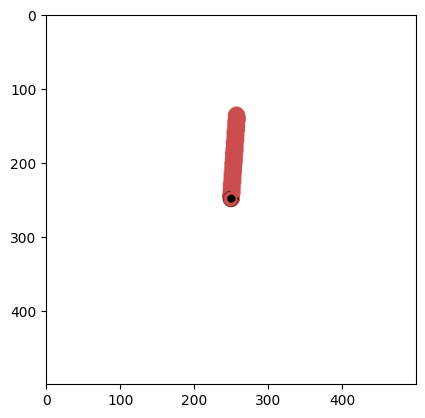

-235.5026465844658

In [37]:
test(play=True)